In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
def display_image(img_fpath: str, target_width: int = 300):
    """
    Display an image with a consistent width while maintaining the aspect ratio.

    Parameters:
        img_fpath (str): Path to the image file.
        target_width (int): The desired width for the image (default is 300 pixels).
    """
    img = Image.open(img_fpath)
    w, h = img.size

    # Calculate the new height to maintain the aspect ratio
    aspect_ratio = h / w
    target_height = int(target_width * aspect_ratio)

    # Resize the image
    img = img.resize((target_width, target_height))
    display(img)

In [3]:
current_dir = os.getcwd()
base_dir = os.path.dirname(current_dir)
data_dir = os.path.join(base_dir, 'data/processed')


In [4]:
df = pd.read_csv(f"{data_dir}/bioreactor_data_problematic.csv")

In [5]:
df

,Timestamp,Batch ID,Temperature (°C),pH,Pressure (kPa),Quality Metric (%),Dissolved Oxygen (%),Conductivity (mS/cm),UV Absorbance,RNA Folding Efficiency (%),Nanopore RNA Integrity (Score),Enzyme Concentration (U/mL)
0,2024-12-08 08:00:00,Batch_001,38.107275,7.321717,100.490226,86.708730,59.391629,14.729690,0.301743,90.025372,8.419629,110.592979
1,2024-12-08 08:15:00,Batch_001,37.968837,7.415947,100.941397,87.822100,61.032041,13.279366,1.657361,93.871107,8.813845,105.625916
2,2024-12-08 08:30:00,Batch_001,37.408535,7.439668,100.695474,92.763296,60.392487,15.221677,1.859735,94.537502,8.345944,123.800014
3,2024-12-08 08:45:00,Batch_001,36.808186,7.460966,101.250553,94.101104,60.629405,16.039229,1.413965,96.031035,8.585404,103.887323
4,2024-12-08 09:00:00,Batch_001,37.626759,7.401403,101.310707,92.208867,61.116176,15.273418,-0.123650,92.789293,8.613030,107.240410
...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-12-09 07:45:00,Batch_003,37.681209,7.515834,101.378554,90.561076,59.244882,14.434512,0.720013,93.046872,7.809654,122.071441
296,2024-12-09 08:00:00,Batch_003,38.399242,7.357286,101.116423,86.182746,58.981271,15.037926,0.816031,90.793619,8.184243,129.071439
297,2024-12-09 08:15:00,Batch_003,37.529792,7.348742,102.700948,85.639828,57.848483,13.891028,1.108147,93.570071,7.795571,102.805039
298,2024-12-09 08:30:00,Batch_003,36.711263,7.399176,101.509033,90.214193,63.947165,15.745305,1.949443,99.425983,9.618155,119.397999


# Starting with EDA 

Data types, summary statistics, null values

In [6]:
print("Dataset Shape:", df.shape)
print("\nColumn Names and Types:\n", df.dtypes)

Dataset Shape: (300, 12)

Column Names and Types:
 Timestamp                          object
Batch ID                           object
Temperature (°C)                  float64
pH                                float64
Pressure (kPa)                    float64
Quality Metric (%)                float64
Dissolved Oxygen (%)              float64
Conductivity (mS/cm)              float64
UV Absorbance                     float64
RNA Folding Efficiency (%)        float64
Nanopore RNA Integrity (Score)    float64
Enzyme Concentration (U/mL)       float64
dtype: object


In [7]:
# Summary statistics per column
df.describe()

,Temperature (°C),pH,Pressure (kPa),Quality Metric (%),Dissolved Oxygen (%),Conductivity (mS/cm),UV Absorbance,RNA Folding Efficiency (%),Nanopore RNA Integrity (Score),Enzyme Concentration (U/mL)
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,37.514571,7.370691,101.443733,89.203319,60.013464,14.947051,0.756751,94.586484,8.714606,114.587316
std,0.456352,0.160876,1.035320,4.384323,1.875766,0.497484,1.013386,3.551802,0.824469,8.499889
min,36.016122,6.543264,98.899868,64.712143,55.315898,13.279366,-1.907412,80.084510,5.712999,100.256049
25%,37.237305,7.319297,100.719576,86.809683,58.650655,14.644952,0.055328,92.559765,8.183432,107.384688
50%,37.549177,7.380443,101.536364,89.519059,60.132429,14.954646,0.695621,94.491731,8.753774,114.236203
75%,37.841248,7.457555,102.178764,92.147926,61.298701,15.296277,1.507284,97.675841,9.348304,121.494913
max,38.787922,7.703563,104.981091,94.980235,66.486363,16.223085,3.319050,99.983493,9.985332,129.970863


In [8]:
# No missing values --> could be fitted with KNN imputer
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Timestamp                         0
Batch ID                          0
Temperature (°C)                  0
pH                                0
Pressure (kPa)                    0
Quality Metric (%)                0
Dissolved Oxygen (%)              0
Conductivity (mS/cm)              0
UV Absorbance                     0
RNA Folding Efficiency (%)        0
Nanopore RNA Integrity (Score)    0
Enzyme Concentration (U/mL)       0
dtype: int64


#  Histograms for Numerical Features

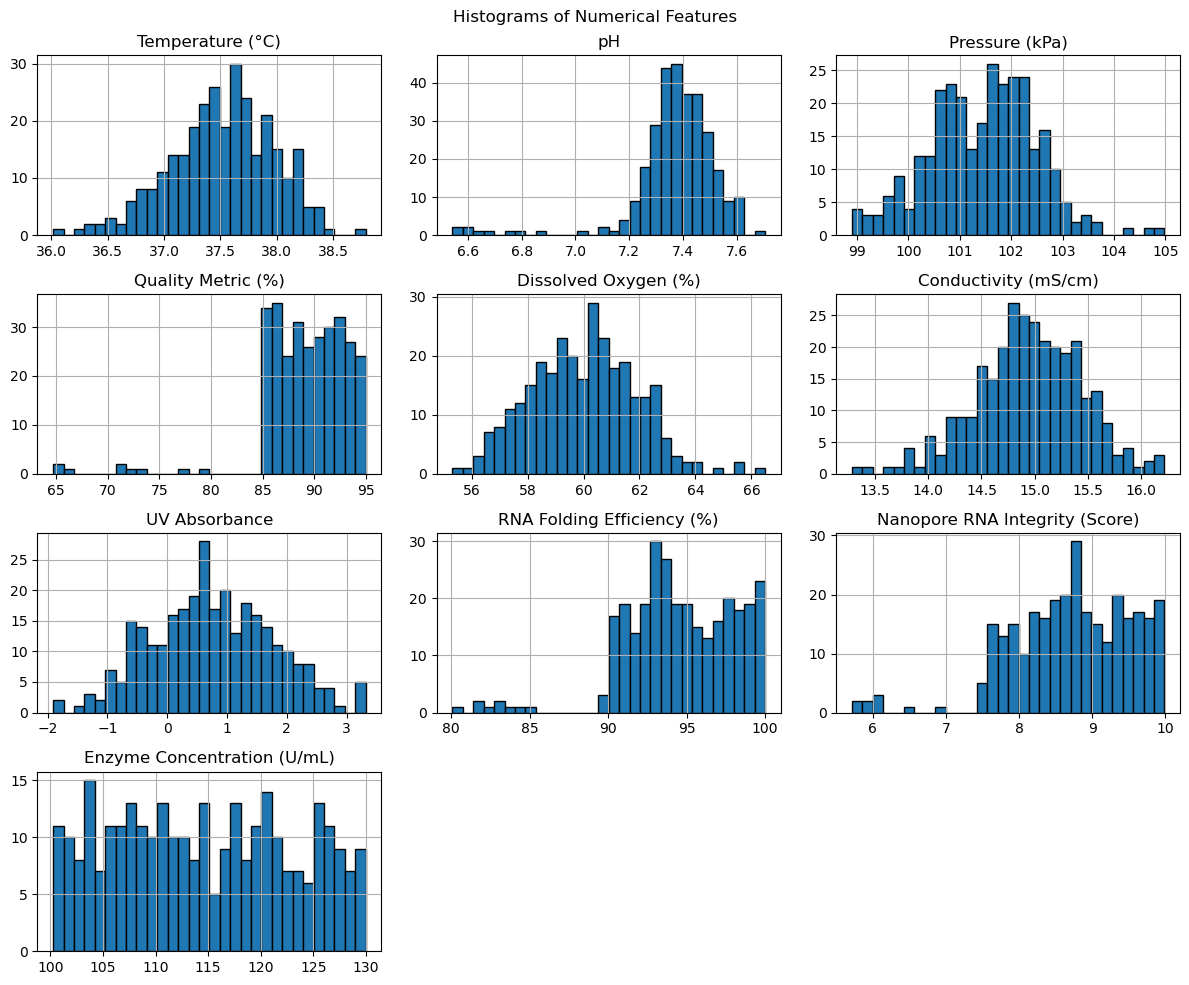

In [9]:

df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.tight_layout()
plt.show()

# Here it is already evident that the data is not normally distributed --> there are outliers in pH, Quality Metric, RNA Folding & Integrity and Temp

# Boxplots for Outlier Detection

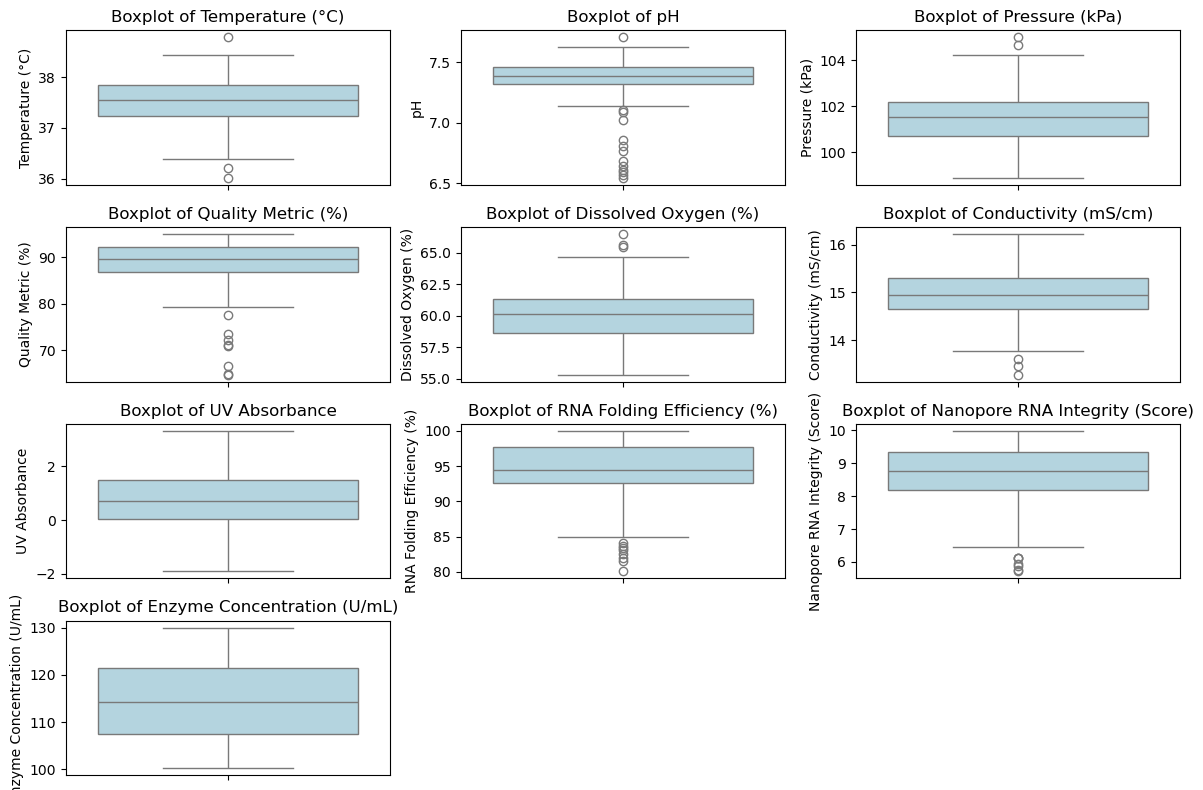

In [10]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.select_dtypes(include=np.number).columns, 1):
    plt.subplot(4, 3, i)  
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# Correlation Between Features representing with Heatmap

Ignore the diagonals

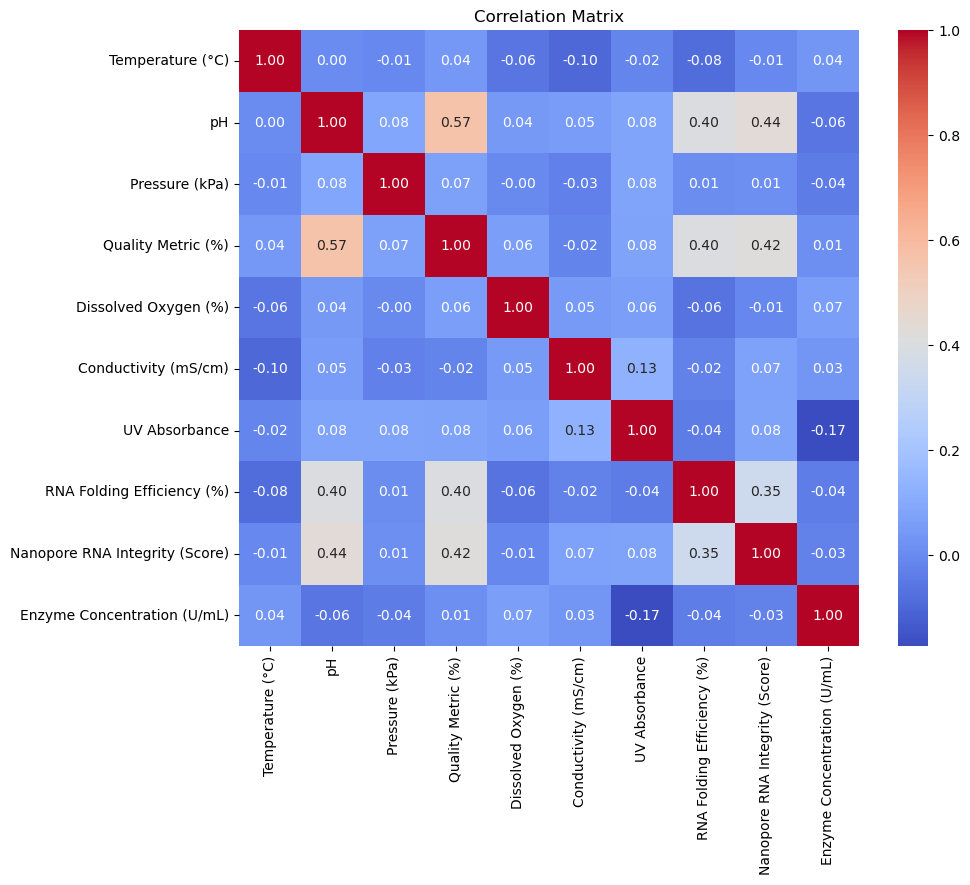

In [11]:
# Correlation Matrix
df_numerical = df.select_dtypes(include=np.number)
correlation_matrix = df_numerical.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


High correlation between pH and Quality Metric and pH with RNA Folding Efficiency

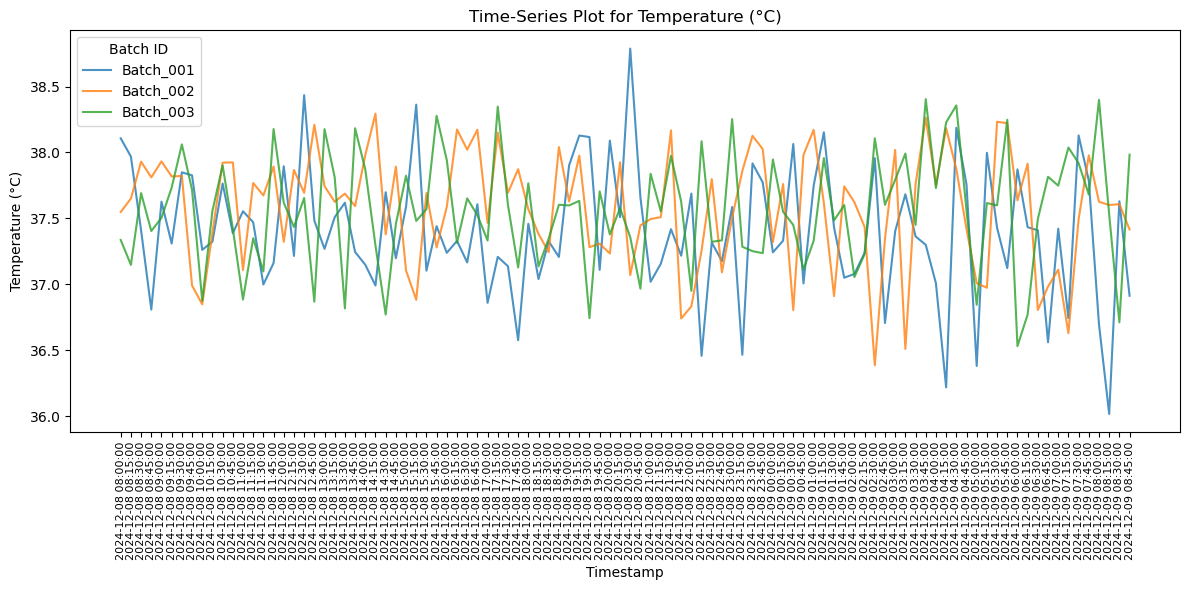

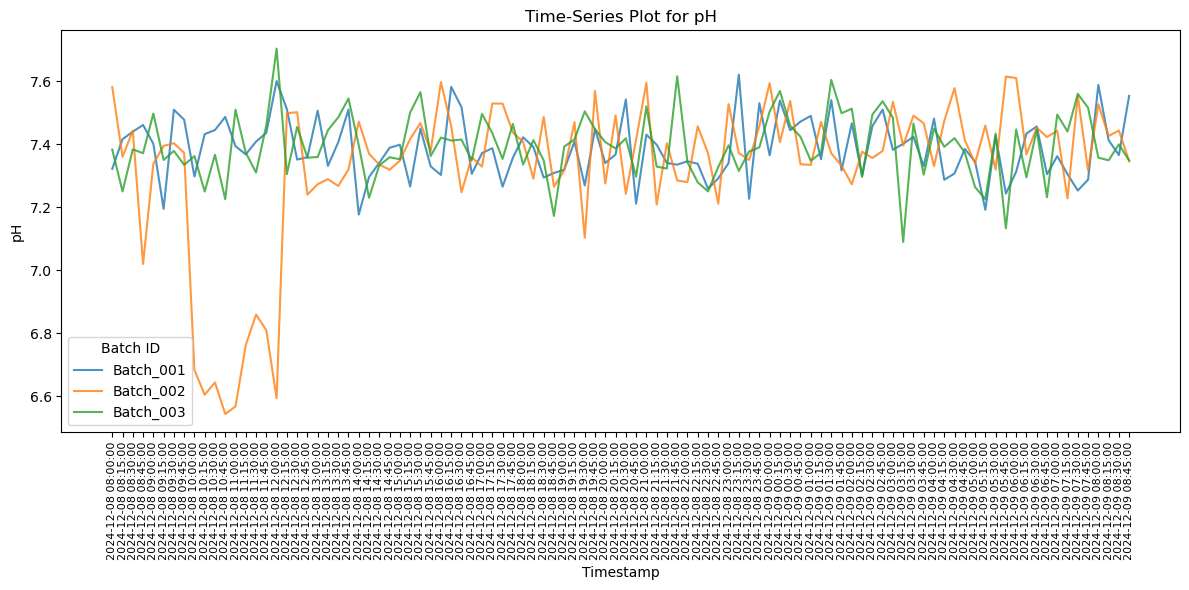

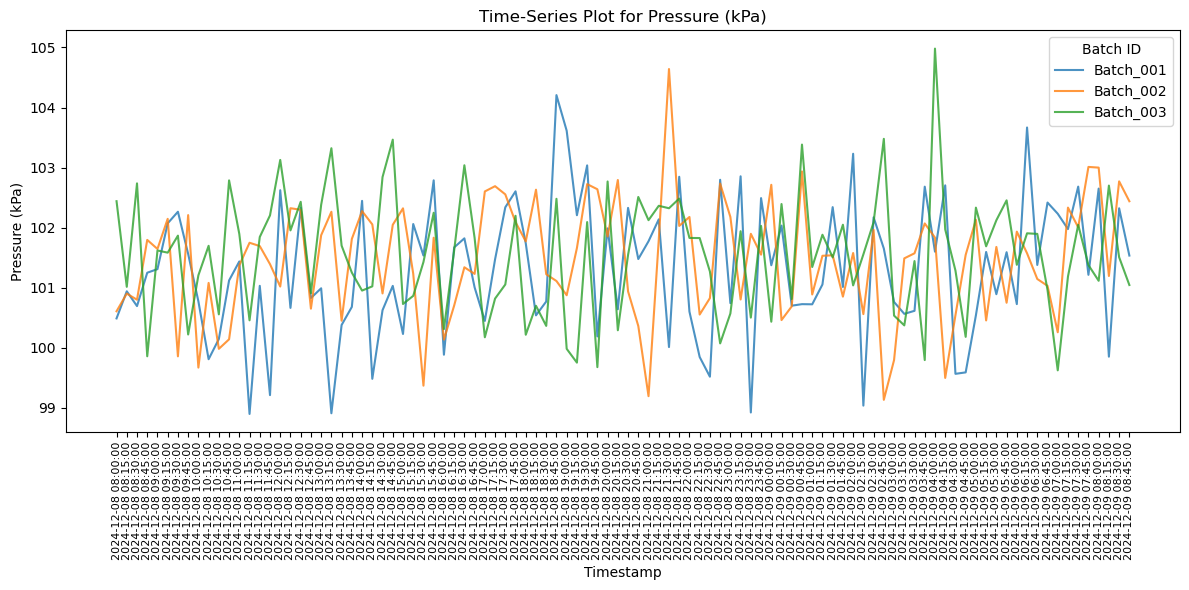

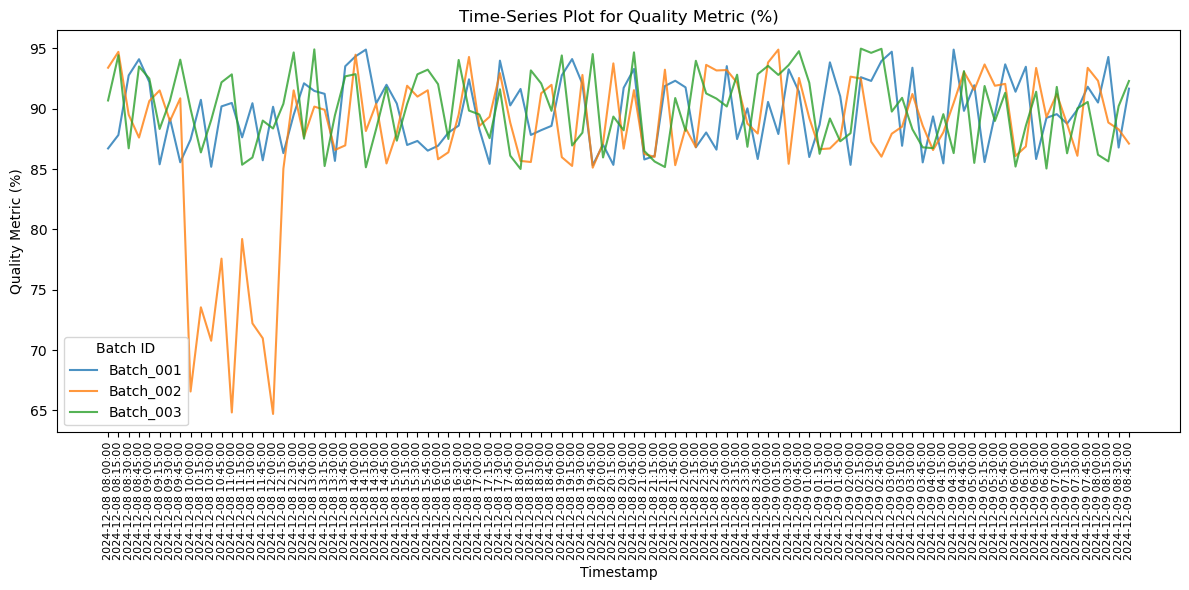

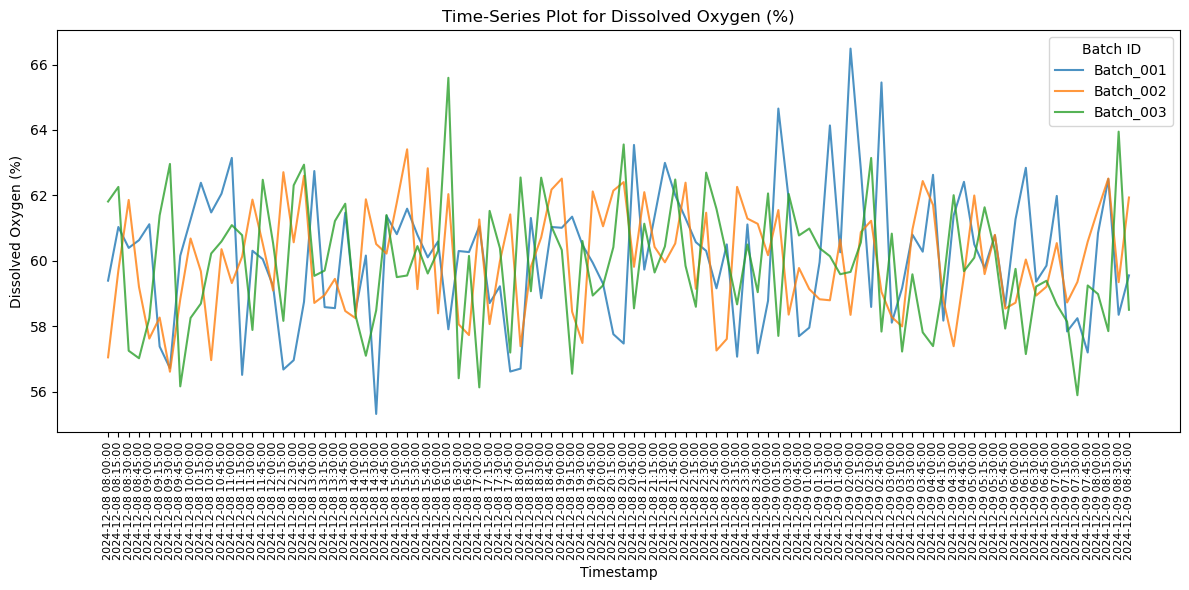

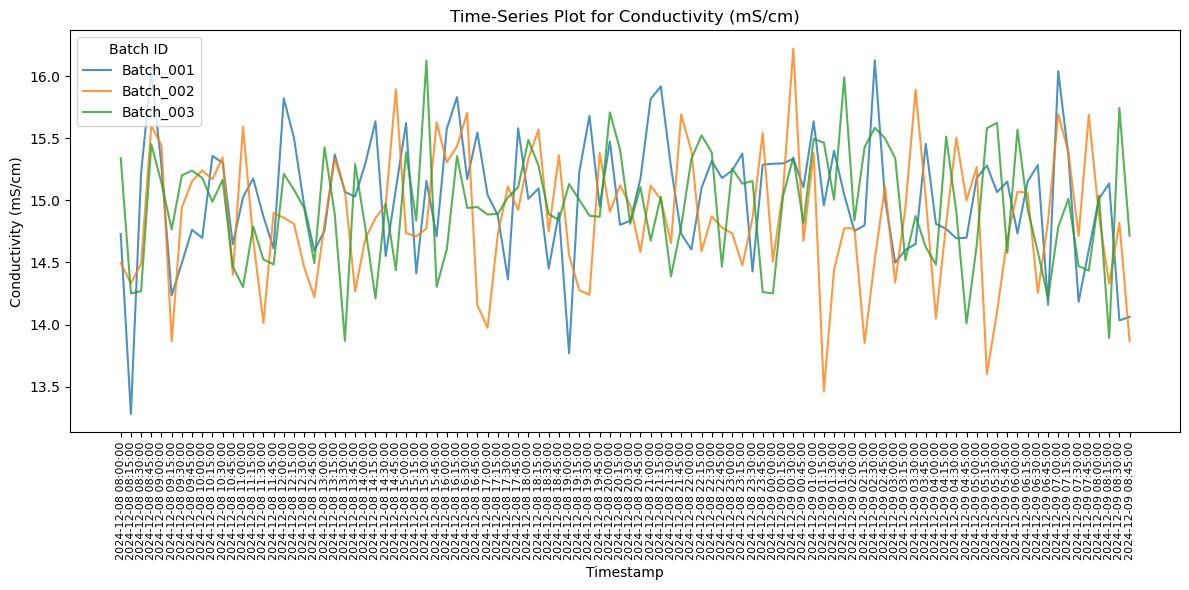

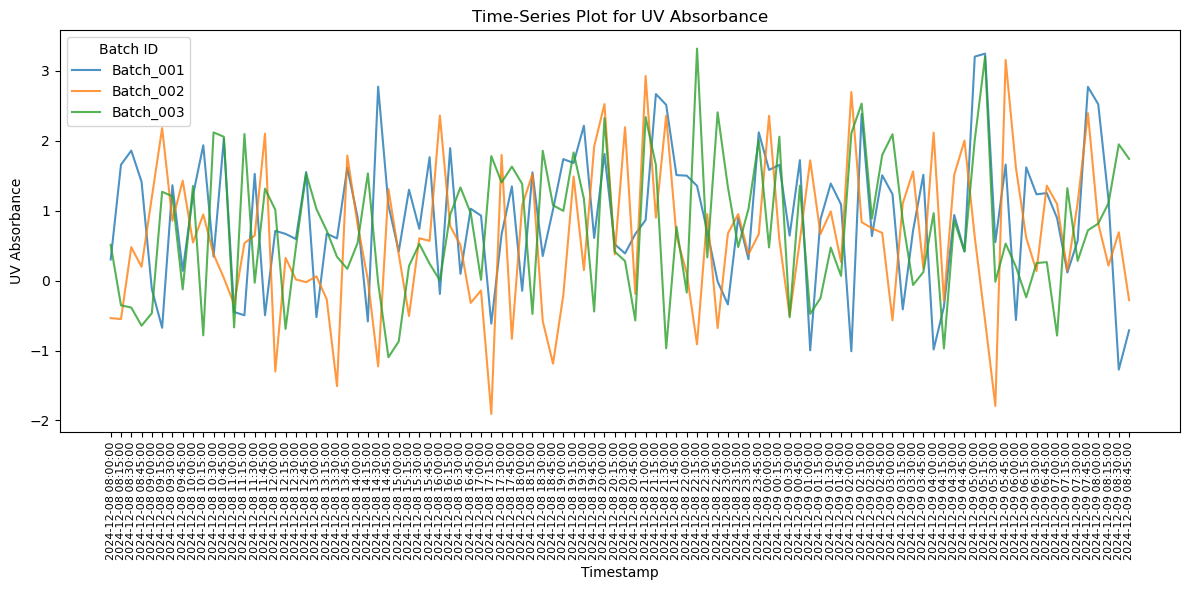

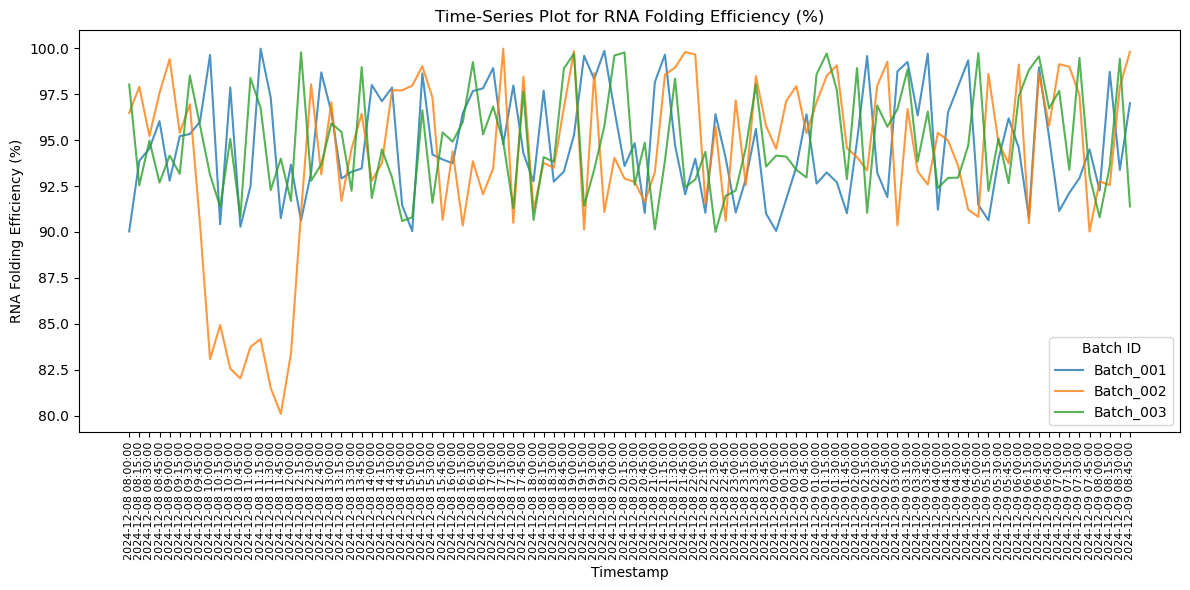

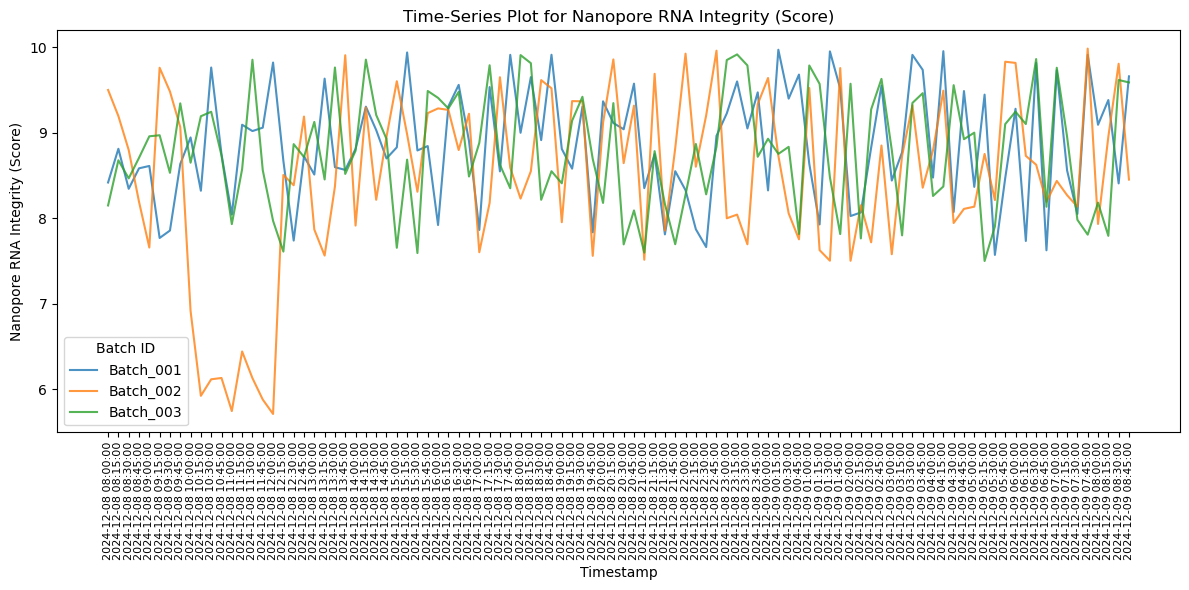

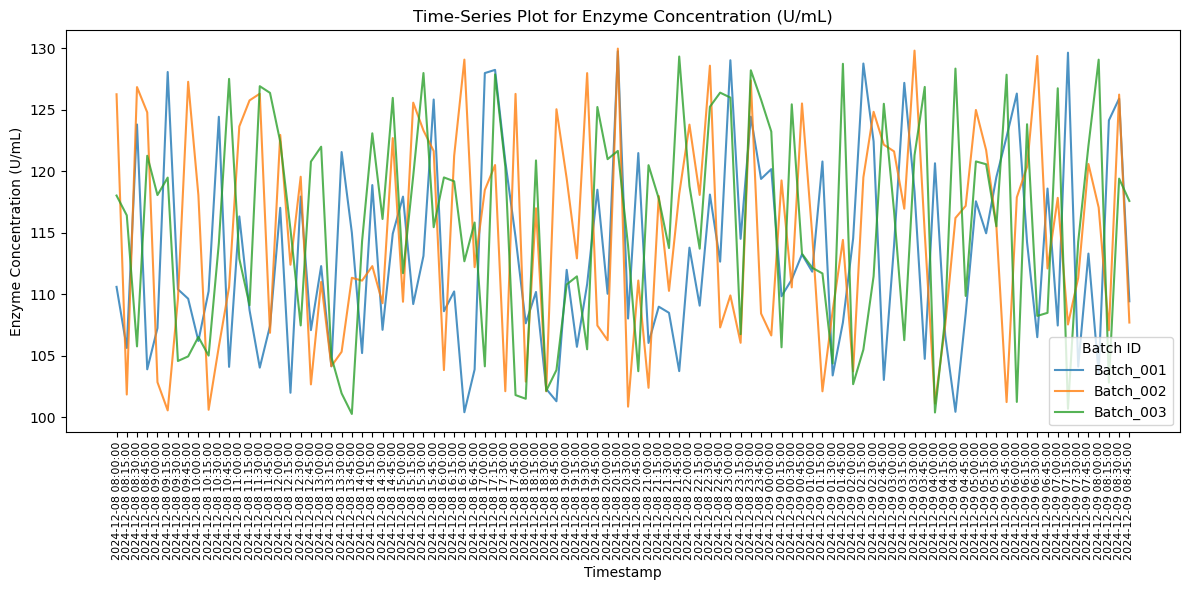

In [12]:
batches = df["Batch ID"].unique()
quantities = [
    "Temperature (°C)", "pH", "Pressure (kPa)", 
    "Quality Metric (%)", "Dissolved Oxygen (%)", 
    "Conductivity (mS/cm)", "UV Absorbance", 
    "RNA Folding Efficiency (%)", "Nanopore RNA Integrity (Score)", 
    "Enzyme Concentration (U/mL)"
]

# Plotting each quantity in a separate figure
for quantity in quantities:
    plt.figure(figsize=(12, 6))
    for batch in batches:
        batch_data = df[df["Batch ID"] == batch]
        plt.plot(batch_data["Timestamp"], batch_data[quantity], label=batch, alpha=0.8)
    plt.title(f"Time-Series Plot for {quantity}")
    plt.xlabel("Timestamp")
    plt.ylabel(quantity)
    plt.xticks(rotation=90, fontsize=8)
    plt.legend(title="Batch ID")
    plt.tight_layout()
    plt.show()

# Z-Score Anomaly Calculation

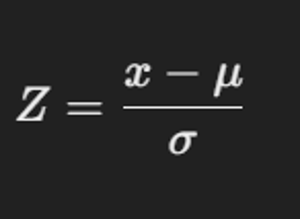

In [13]:
from PIL import Image
display_image(img_fpath=base_dir+'/zscore.png')

Where:
- \(Z\): The Z-score for the data point \(x\).
- \(x\): The data point being evaluated.
- \(\mu\): The mean of the dataset \(X\).
- \(\sigma\): The standard deviation of the dataset \(X\).


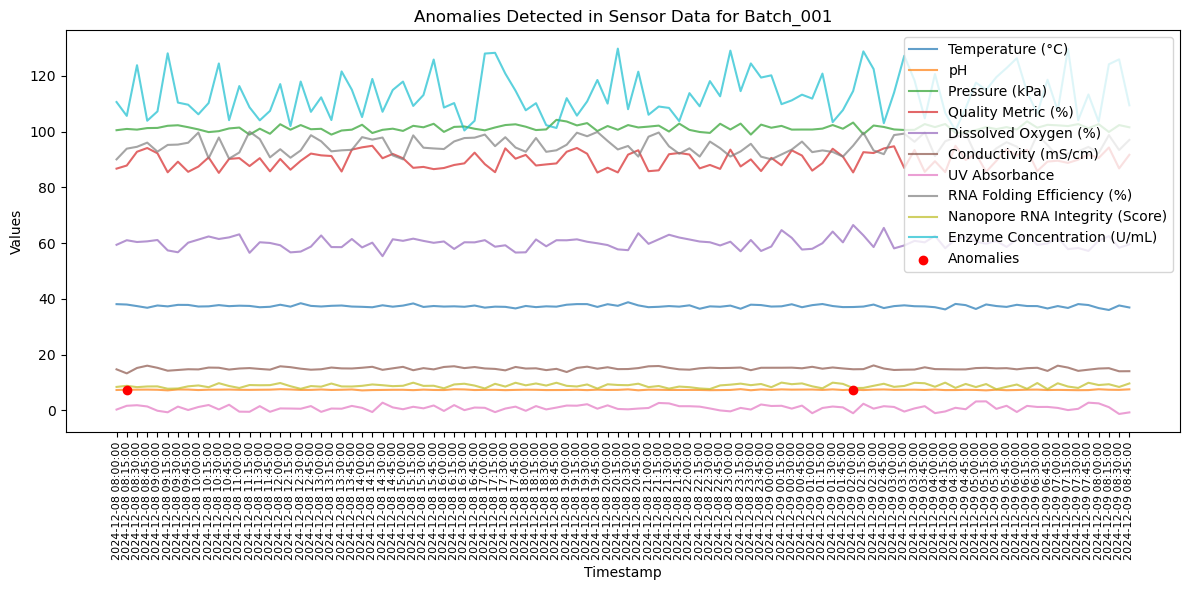

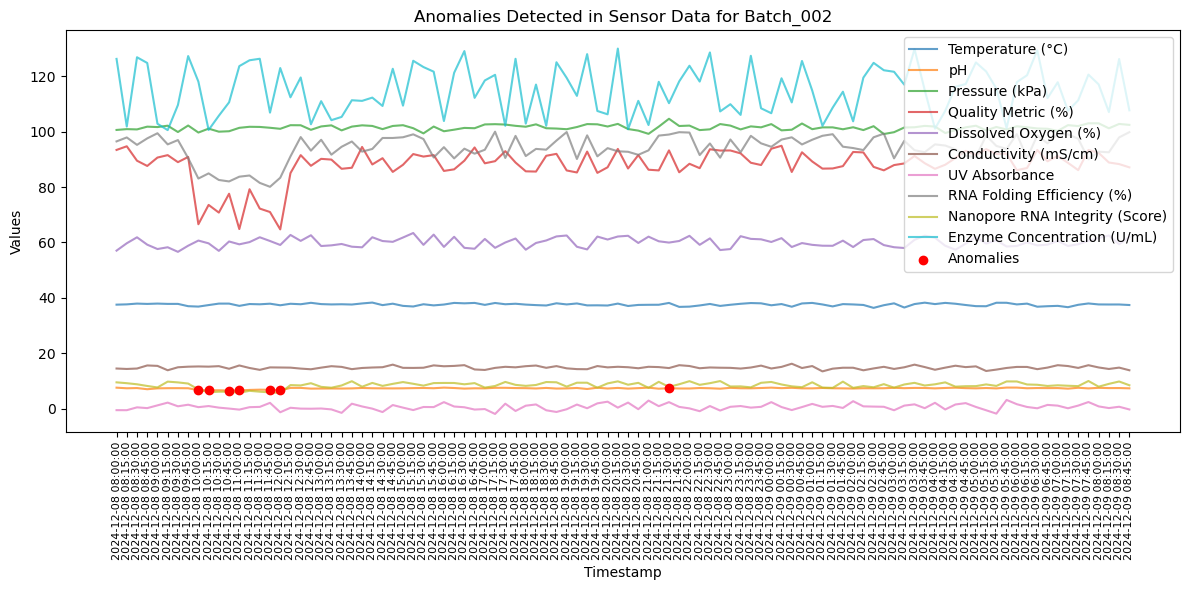

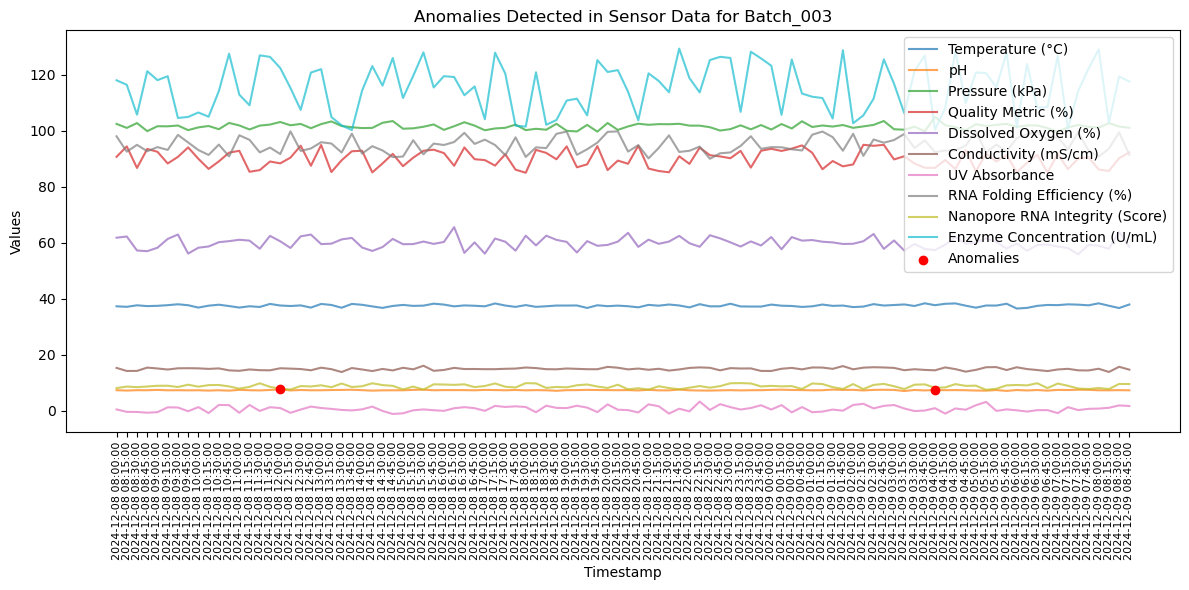

Anomaly Counts Per Batch: {'Batch_001': np.int64(2), 'Batch_002': np.int64(7), 'Batch_003': np.int64(2)}


In [14]:
anomaly_counts = {}

# Process each batch separately
for batch in batches:
    batch_data = df[df["Batch ID"] == batch].copy()
    
  
    z_scores = batch_data.select_dtypes(include=np.number).apply(zscore)
    
   
    threshold = 3
    anomalies = (z_scores.abs() > threshold).any(axis=1)
    batch_data["Potential_Anomaly"] = anomalies
    
    # Save anomaly count for this batch
    anomaly_counts[batch] = batch_data["Potential_Anomaly"].sum()
    
    # Highlight Anomalies in Time-Series Plot for the Batch
    plt.figure(figsize=(12, 6))
    for col in batch_data.select_dtypes(include=np.number).columns:
        if col not in ["Potential_Anomaly"]:  # Skip non-numeric fields
            plt.plot(batch_data["Timestamp"], batch_data[col], label=col, alpha=0.7)
    
    # Plot Anomalies
    anomalies_data = batch_data[batch_data["Potential_Anomaly"]]
    if not anomalies_data.empty:
        plt.scatter(anomalies_data["Timestamp"], anomalies_data["pH"], color="red", label="Anomalies", zorder=5)
    
    plt.legend()
    plt.title(f"Anomalies Detected in Sensor Data for {batch}")
    plt.xlabel("Timestamp")
    plt.ylabel("Values")
    plt.xticks(rotation=90, fontsize=8)  # Smaller x-axis labels
    plt.tight_layout()
    plt.show()

# Print total anomaly counts per batch
print("Anomaly Counts Per Batch:", anomaly_counts)


99.7% of data lies within 3 standard deviations (
−
3
<
𝑍
<
3
) to a p-value of approximately 0.0027 (0.27%)

# Zooming on anomalies 

Specific Plotting

In [15]:
# Recalculate Z-Scores and Anomalies to Ensure Consistency
for batch in batches:
    batch_data = df[df["Batch ID"] == batch].copy()
    
    # Compute Z-Scores
    z_scores = batch_data.select_dtypes(include=np.number).apply(zscore)
    
    # Identify Anomalies
    threshold = 3
    anomalies = (z_scores.abs() > threshold).any(axis=1)
    batch_data["Potential_Anomaly"] = anomalies
    
    # Update the main DataFrame
    df.loc[df["Batch ID"] == batch, "Potential_Anomaly"] = batch_data["Potential_Anomaly"]


In [16]:
# Re-run the Anomaly Summary
anomaly_summary = {}

for batch in batches:
    batch_data = df[df["Batch ID"] == batch].copy()
    anomaly_count = batch_data["Potential_Anomaly"].sum()
    total_points = len(batch_data)
    anomaly_percentage = (anomaly_count / total_points) * 100
    anomaly_summary[batch] = {
        "Total Points": total_points,
        "Anomalies Detected": anomaly_count,
        "Anomaly Percentage (%)": anomaly_percentage
    }

# Convert to DataFrame for visualization
anomaly_summary_df = pd.DataFrame.from_dict(anomaly_summary, orient="index")

# Display summary
print("Batch-Specific Anomaly Summary:")
print(anomaly_summary_df)


Batch-Specific Anomaly Summary:
           Total Points  Anomalies Detected  Anomaly Percentage (%)
Batch_001           100                   2                     2.0
Batch_002           100                   7                     7.0
Batch_003           100                   2                     2.0


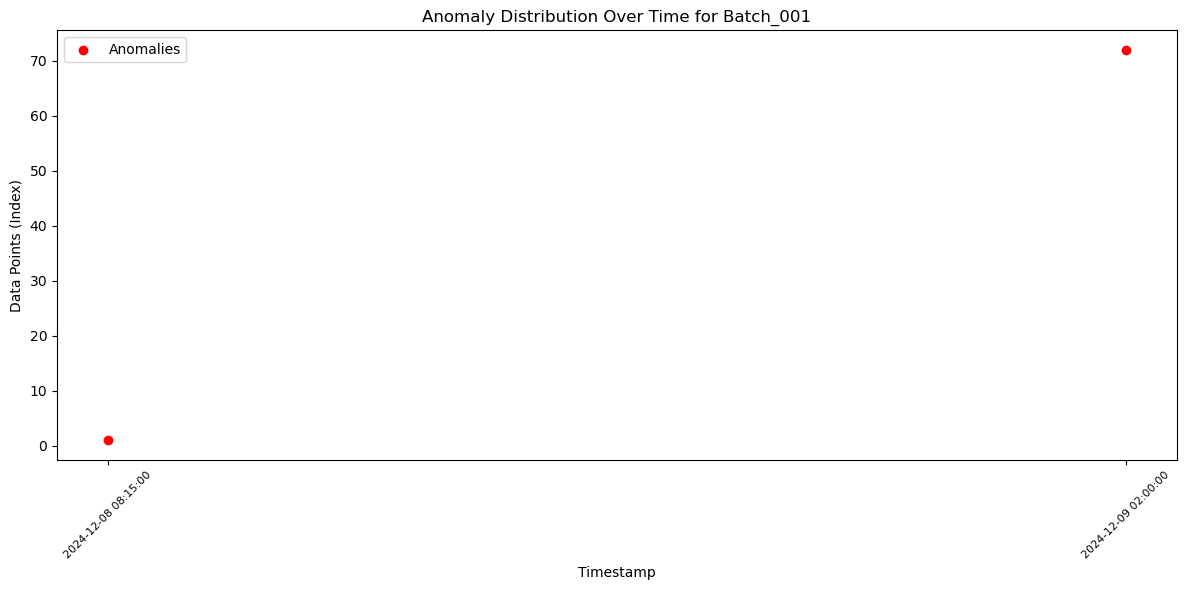

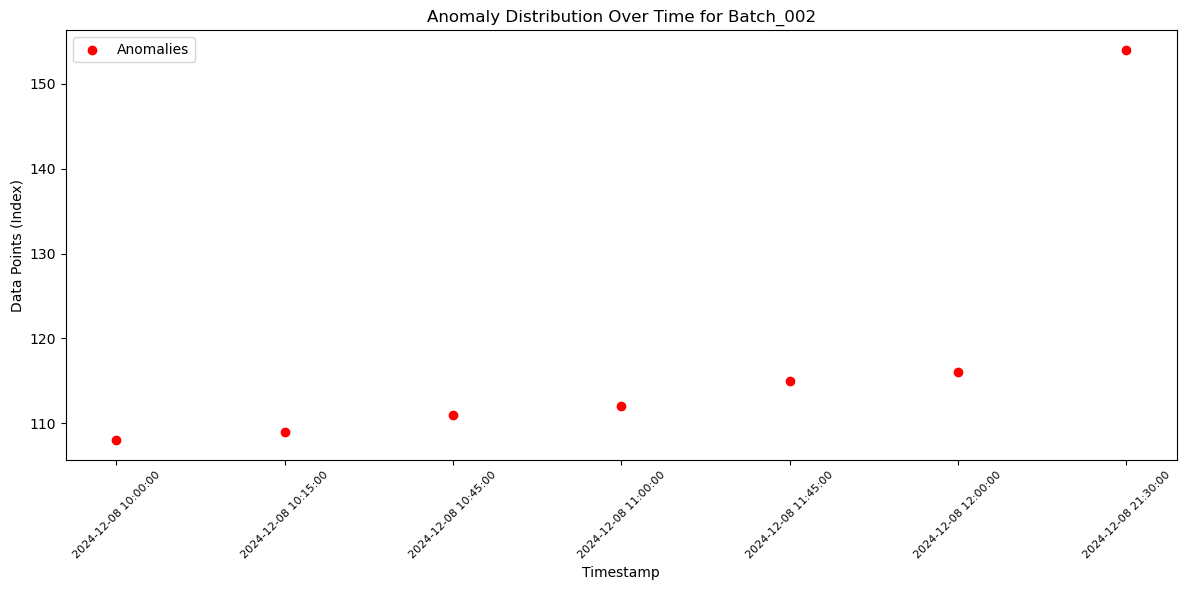

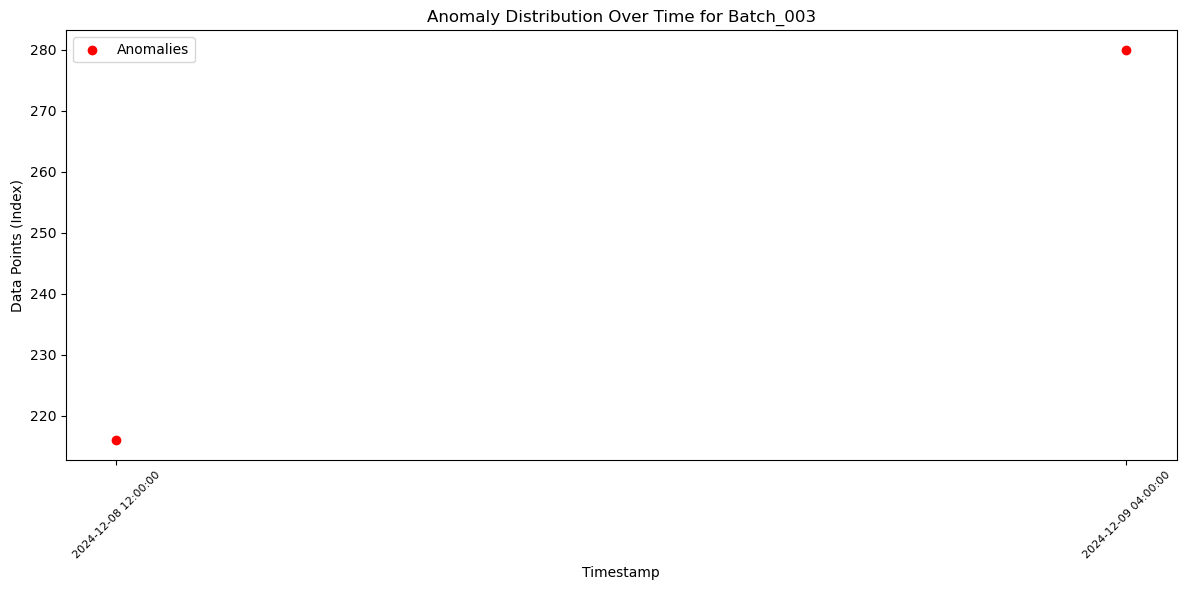

In [17]:
for batch in batches:
    batch_data = df[df["Batch ID"] == batch].copy()
    anomalies_data = batch_data[batch_data["Potential_Anomaly"]]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(anomalies_data["Timestamp"], anomalies_data.index, color="red", label="Anomalies")
    plt.title(f"Anomaly Distribution Over Time for {batch}")
    plt.xlabel("Timestamp")
    plt.ylabel("Data Points (Index)")
    plt.xticks(rotation=45, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()


# A simple machine learning model for pattern recognition

In [18]:
print(df["Potential_Anomaly"].unique())
df["Potential_Anomaly"] = df["Potential_Anomaly"].astype(int)  # Convert False/True to 0/1


[False True]


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        58
           1       0.50      1.00      0.67         2

    accuracy                           0.97        60
   macro avg       0.75      0.98      0.82        60
weighted avg       0.98      0.97      0.97        60

Confusion Matrix:
 [[56  2]
 [ 0  2]]


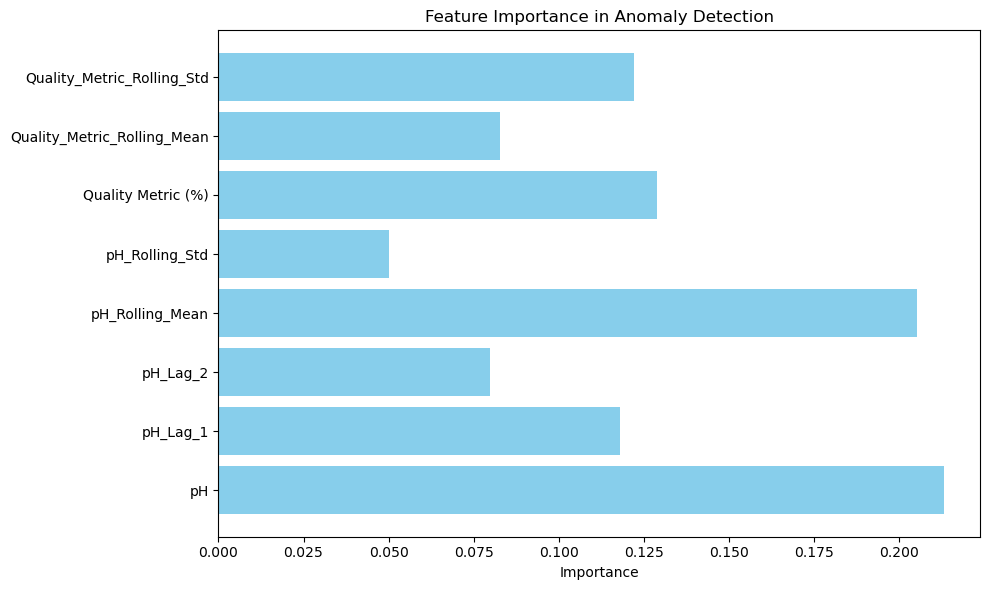

/tmp/ipykernel_257173/4116085876.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly_Predicted"] = model.predict(X)


In [19]:
window = 2  # Short-term rolling window (30 minutes)
df["pH_Lag_1"] = df["pH"].shift(1)
df["pH_Lag_2"] = df["pH"].shift(2)
df["pH_Rolling_Mean"] = df["pH"].rolling(window=window).mean()
df["pH_Rolling_Std"] = df["pH"].rolling(window=window).std()
df["Quality_Metric_Rolling_Mean"] = df["Quality Metric (%)"].rolling(window=window).mean()
df["Quality_Metric_Rolling_Std"] = df["Quality Metric (%)"].rolling(window=window).std()

# Drop rows with NaN values due to lagging/rolling
df = df.dropna()

# Prepare features and target
X = df[[
    "pH", "pH_Lag_1", "pH_Lag_2", "pH_Rolling_Mean", "pH_Rolling_Std",
    "Quality Metric (%)", "Quality_Metric_Rolling_Mean", "Quality_Metric_Rolling_Std"
]]
y = df["Potential_Anomaly"]

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
feature_importances = model.feature_importances_
feature_names = [
    "pH", "pH_Lag_1", "pH_Lag_2", "pH_Rolling_Mean", "pH_Rolling_Std",
    "Quality Metric (%)", "Quality_Metric_Rolling_Mean", "Quality_Metric_Rolling_Std"
]

# Feature Importance Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance in Anomaly Detection")
plt.tight_layout()
plt.show()

# Add predictions back to the original DataFrame
df["Anomaly_Predicted"] = model.predict(X)

# Save processed DataFrame for Tableau visualization
df.to_csv("supervised_anomaly_detection_results.csv", index=False)



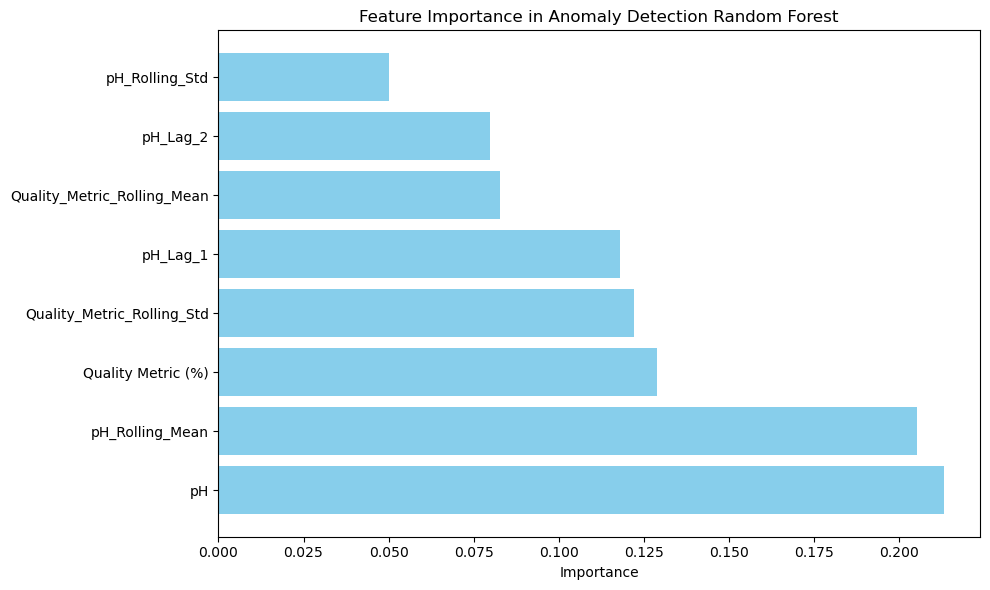

In [20]:
import numpy as np

# Sort feature importance in descending order and adjust feature names accordingly
sorted_indices = np.argsort(feature_importances)[::-1]  # Indices for sorting in descending order
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importance in Anomaly Detection Random Forest")
plt.tight_layout()
plt.show()


In [21]:
df.columns

Index(['Timestamp', 'Batch ID', 'Temperature (°C)', 'pH', 'Pressure (kPa)',
       'Quality Metric (%)', 'Dissolved Oxygen (%)', 'Conductivity (mS/cm)',
       'UV Absorbance', 'RNA Folding Efficiency (%)',
       'Nanopore RNA Integrity (Score)', 'Enzyme Concentration (U/mL)',
       'Potential_Anomaly', 'pH_Lag_1', 'pH_Lag_2', 'pH_Rolling_Mean',
       'pH_Rolling_Std', 'Quality_Metric_Rolling_Mean',
       'Quality_Metric_Rolling_Std', 'Anomaly_Predicted'],
      dtype='object')

/tmp/ipykernel_257173/668256940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anomaly_Predicted"] = df["Anomaly_Predicted"].astype(bool)


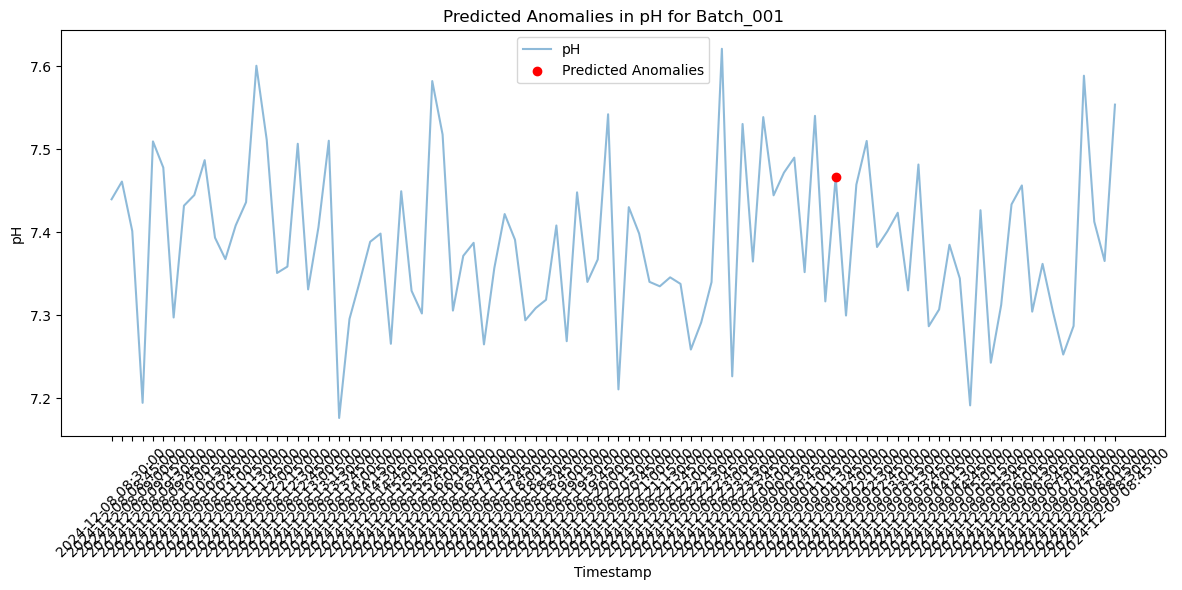

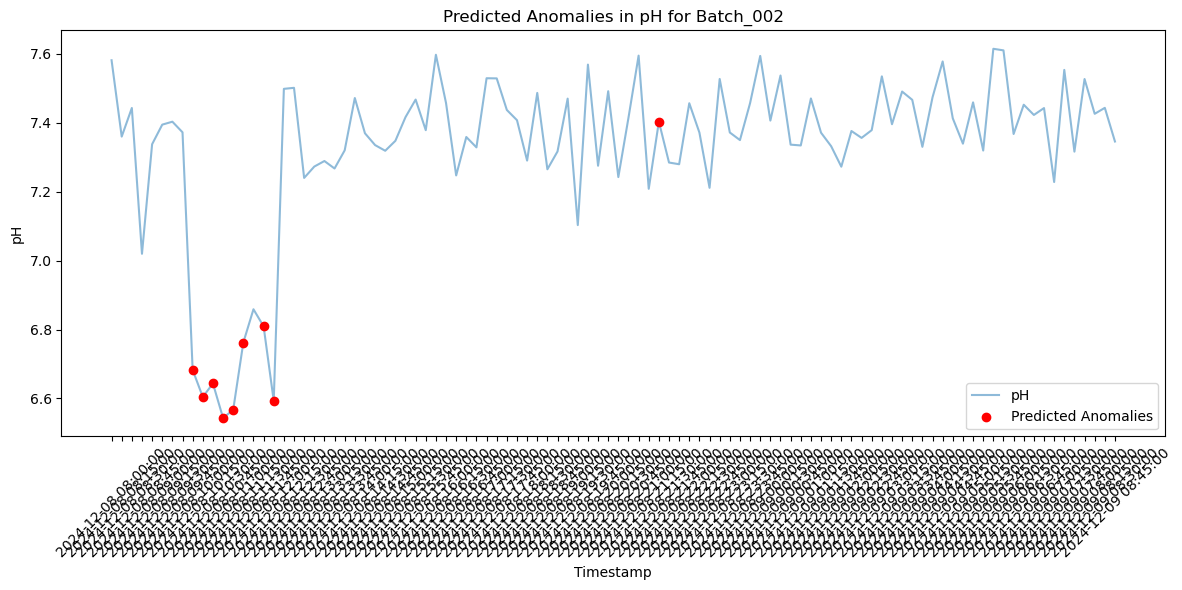

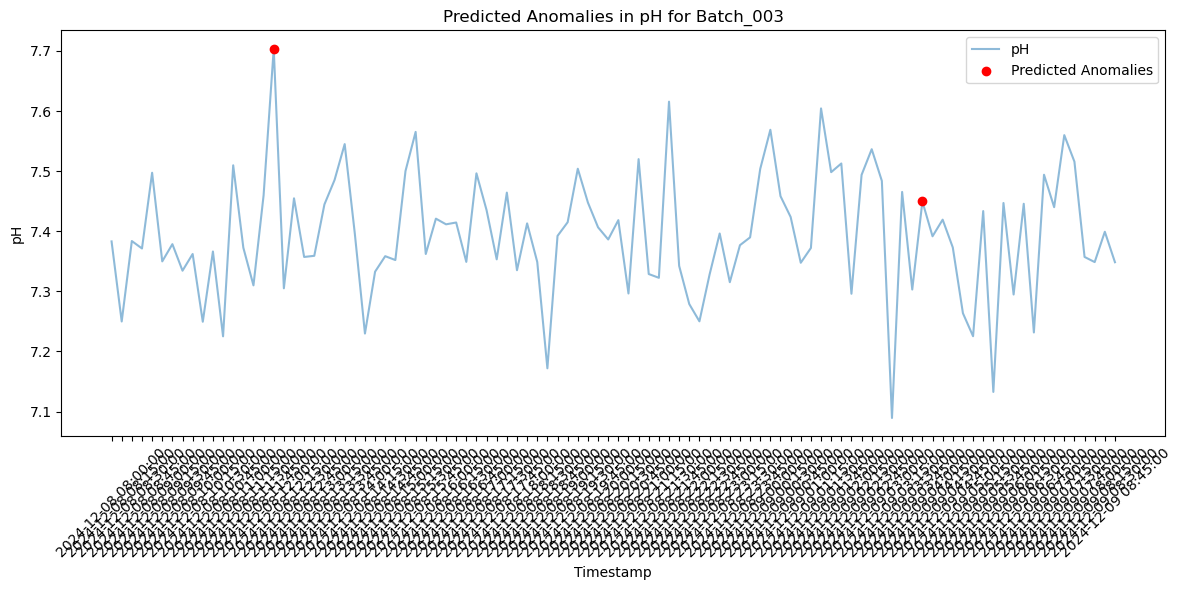

In [22]:
# Visualization of Predicted Anomalies
# Ensure Anomaly_Predicted is boolean
df["Anomaly_Predicted"] = df["Anomaly_Predicted"].astype(bool)

# Plot predicted anomalies for each batch
batches = df["Batch ID"].unique()

for batch in batches:
    batch_data = df[df["Batch ID"] == batch]
    
    plt.figure(figsize=(12, 6))
    plt.plot(batch_data["Timestamp"], batch_data["pH"], label="pH", alpha=0.5)
    
    # Highlight anomalies in the batch
    anomalies = batch_data[batch_data["Anomaly_Predicted"]]
    plt.scatter(anomalies["Timestamp"], anomalies["pH"], color="red", label="Predicted Anomalies", zorder=5)
    
    plt.title(f"Predicted Anomalies in pH for {batch}")
    plt.xlabel("Timestamp")
    plt.ylabel("pH")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
